In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import mpmath
import time

import warnings
warnings.filterwarnings("ignore")


import pygsp as pg
import plotly

## Delay Measure framework

In [2]:
def delay_measure(signal, return_meas = False):
    n_regions = len(signal[0])
    n_timepoints = len(signal)
    
    # Initialization of data vectors
    activ = np.zeros(n_regions)
    delay_meas = np.zeros((n_regions, n_regions, n_timepoints))
    
    # Scanning through time
    for t, vox in enumerate(signal):
        # Progression Verbose
        if t % np.ceil(n_timepoints/4) == 0:
            print(t, 'out of', n_timepoints)
        
        # Compute delay and update activation list iif at least one region is active
        if any(vox):
            # Store index of previously (act) and newly (vox) activated regions 
            act_idx = np.where(activ != 0)[0]
            vox_idx = np.where(vox != 0)[0]
            
            # Computation of time delay between 
            for vox_id in vox_idx:
                delay_meas[act_idx,vox_id, t] = (t + 1 - activ[activ!=0])
            
            # Update activation list and times
            activ[np.where(vox != 0)] = t + 1
    
    print('Almost there')
    
    # Compute mean and STD of delay
    delay_mean = np.empty((n_regions, n_regions))
    delay_std = np.empty_like(delay_mean)
    
    for i in range(n_regions):
        for j in range(n_regions):
            delay_mean[i, j] = delay_meas[i, j][delay_meas[i, j] != 0].mean()
            delay_std[i, j] = delay_meas[i, j][delay_meas[i, j] != 0].std()
    
    print('––[ DONE ]––')
    
    # Condition to return actual measurements (CARE: big thing)
    if return_meas:
        return delay_meas, delay_mean, delay_std
    else:
        return delay_mean, delay_std

## Generation of ideal random activation
Simulation of sparse innovation signals by thresholding randomly distributed signal at 95%–98% percentile.

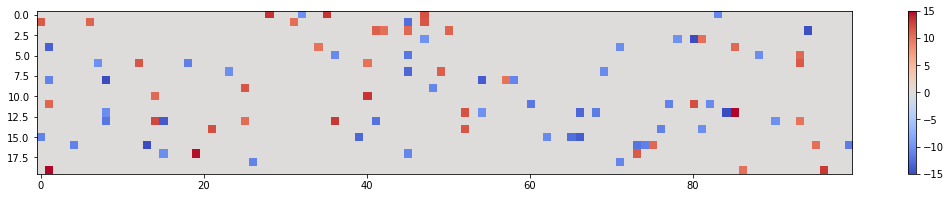

In [28]:
innovation = np.random.normal(np.zeros((100,20)), 5)
innovation[abs(innovation) < np.percentile(innovation, 98)] = 0

fig, ax = plt.subplots(figsize = (20, 3))
plt.imshow(innovation.T, cmap = 'coolwarm', vmin = -15, vmax =15)
plt.colorbar() 

0 out of 100
25 out of 100
50 out of 100
75 out of 100
Almost there
––[ DONE ]––


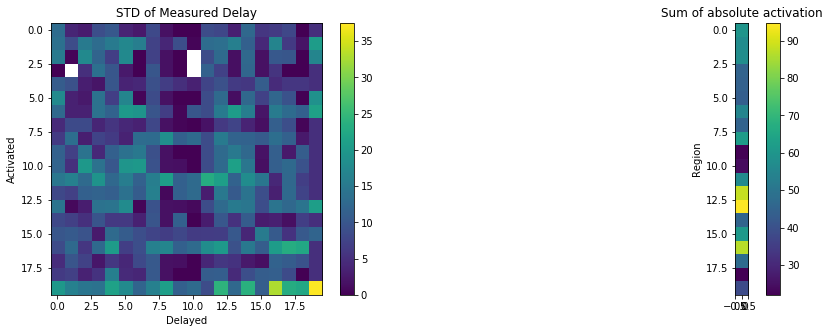

In [31]:
# Measurement of delay in synthetic data (random patterns)
delay_100_mean, delay_100_std = delay_measure(innovation)

fig, ax = plt.subplots(figsize = (14, 5))

plt.subplot(1, 2, 1)
plt.title('STD of Measured Delay')
plt.imshow(delay_100_std)
plt.xlabel('Delayed')
plt.ylabel('Activated')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Sum of absolute activation')
plt.imshow(np.abs(innovation).sum(axis = 0).reshape(-1,1))
plt.ylabel('Region')
plt.colorbar()

## Patterned activation
- Some voxels or regions are randomly selected as seeds with their activity beeing the same as the one described earlier (tresholded randomly distributed signal)
- Some other voxels or regions are randomly selected as followers (of the seeds)
    - Each voxel is randomly assigned to a seed
    - The activity of a follower follows the activity of its assigned seed with a randomly distrbuted delay following a normal distribution: $\mathcal{N}(\mu_{\text{delay}}, \sigma_{\text{delay}})$
    - Also, there is a non-zero probability that the activation of a seed will not trigger the activation of a follower
- The rest of the voxels have random activity as described earlier.

[4, 5, 1, 2, 4, 8, 7, 3, 5, 7, 6, 6, 6, 6, 8, 9, 3, 4, 2, 9]


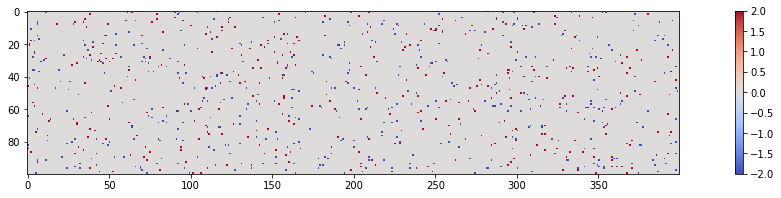

In [80]:
def gen_follower(seed, delay, activ_prob = 90, rand_delay = 1,
                 noise = False):
    
    follower = np.zeros_like(seed)
    
    # Computation of random delay
    shift = np.where(seed != 0)
    shift += delay + np.random.normal(np.zeros_like(shift), rand_delay)
    shift = np.ceil(shift).astype(int)
    
    shift[shift >= len(seed)] -= len(seed)
    
    # Assign a random value (from the value of the activity of the seed) to the followers
    follower[shift] = np.random.choice(seed[seed != 0], len(shift))
    
    # Randomly set activity of a follower to 0 with probability "activ_prob"
    activ_id = np.where(follower != 0)[0]
    rand_discard = np.random.choice(activ_id,
                                    int(np.ceil((1 - activ_prob/100) * len(activ_id))))
    follower[rand_discard] = 0
    
    return follower

def simulate_activation(n_regions = 20, n_seeds = 2, n_followers = 2,
                         n_timepoints = 400, delay = 10, activ_proba = [1, 70]):

    # Initialization of time course with random activities
    time_course = np.random.normal(np.zeros((n_regions, n_timepoints)), 1)

    # Random group allocation of region id
    non_random_id = np.random.choice(n_regions, n_seeds + n_followers, replace = False)
    
    seeds_id = non_random_id[:n_seeds]
    followers_id = non_random_id[n_seeds:n_seeds + n_followers]

    # Generation of random activity (all regions)
    for region in time_course:
        thresh = np.percentile(region, 100 - activ_proba[0])
        region[abs(region) < thresh] = 0
    
    # Generation of followers states (random choice of seed)
    seed_choice = []
    for i in range(n_followers):
        seed_choice.append(np.random.choice(n_seeds))
        chosen = time_course[seeds_id[seed_choice[i]]]
        # Generation of follower
        time_course[followers_id[i]] = gen_follower(chosen, delay, activ_proba[1])
        
    print(seed_choice)
    
    return time_course, seeds_id, followers_id, seed_choice

simulation, seed_id, fol_id, seed_choice = simulate_activation(n_regions = 100,
                                                               n_seeds = 10,
                                                               n_followers = 20,
                                                               n_timepoints = 400,
                                                               delay = 3)

fig, ax = plt.subplots(figsize = (20, 3))
plt.imshow(simulation, cmap = 'coolwarm', vmin = -2, vmax = 2)
plt.colorbar()

[94 83 57 46 77 41 40 74 81 97]
[73 25 65 52 19 49 63 56 92 17 75 71 54 70 80 64 45 22 35 86]
0 out of 400
100 out of 400
200 out of 400
300 out of 400
Almost there
––[ DONE ]––


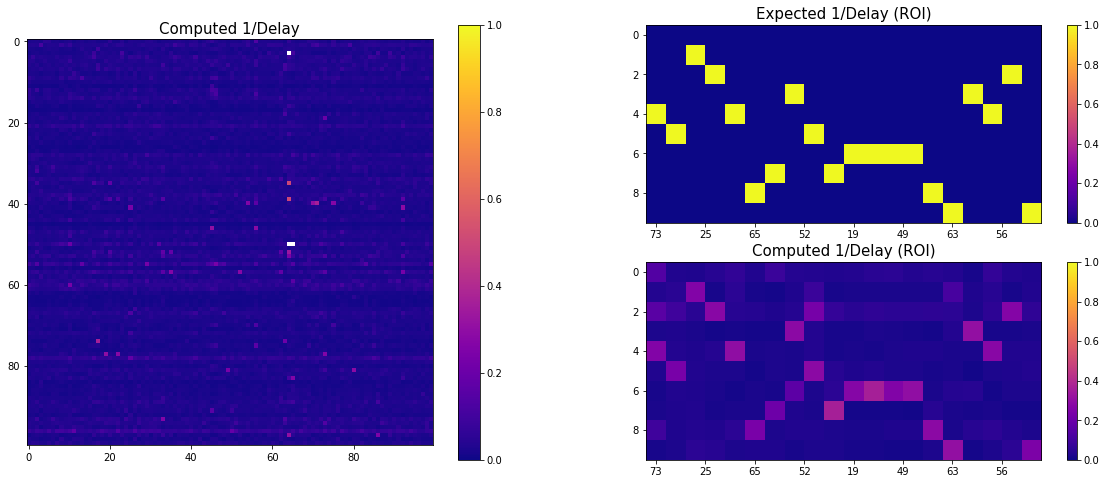

In [81]:
print(seed_id)
print(fol_id)

colmap = 'plasma'

del_std, _ = delay_measure(simulation.T)

fig, ax = plt.subplots(figsize = (20, 8))

# Plotting 1/Delay Matrix
sub_ax = plt.subplot(1, 2, 1)
plt.title('Computed 1/Delay', fontsize = 15)

plt.imshow(1/del_std, cmap = colmap, vmin = 0, vmax = 1)
plt.colorbar()

# Plotting Expected ROI
sub_ax = plt.subplot(2, 2, 2)
plt.title('Expected 1/Delay (ROI)', fontsize = 15)

highlight = [[i for i in seed_id for j in fol_id], [j for i in seed_id for j in fol_id]]

expected = np.zeros_like(del_std)

for f_id, chosen in zip(fol_id, seed_choice):
    expected[seed_id[seed_choice], fol_id] = 1

plt.imshow(expected[highlight].reshape(len(seed_id), -1), cmap = colmap, vmin = 0, vmax = 1)

sub_ax.set_xticklabels(np.insert(fol_id, 0, 0))
plt.colorbar()

# Plotting Obtained ROI
sub_ax = plt.subplot(2, 2, 4)
plt.title('Computed 1/Delay (ROI)', fontsize = 15)

highlight = [[i for i in seed_id for j in fol_id], [j for i in seed_id for j in fol_id]]

plt.imshow(1/del_std[highlight].reshape(len(seed_id), -1), cmap = colmap, vmin = 0, vmax = 1)

#sub_ax.set_yticklabels(np.insert(seed_id,0, 0))
sub_ax.set_xticklabels(np.insert(fol_id, 0, 0))
plt.colorbar()

[1, 2, 0, 2]


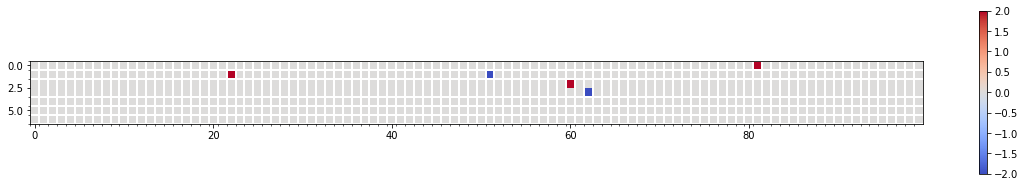

In [79]:
sim, s_ids, f_ids, s_choice = simulate_activation(n_timepoints = 100,
                                                  n_seeds = 3, n_followers = 4)

fig, ax = plt.subplots(figsize = (20, 3))
plt.imshow(np.vstack((sim[s_ids], sim[f_ids])), cmap = 'coolwarm', vmin = -2, vmax = 2)

# Minor ticks
ax.set_xticks(np.arange(-.5, 99, 1), minor=True);
ax.set_yticks(np.arange(-.5, 7, 1), minor=True);

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.colorbar()